<img src='../images/cbslogo.jpg' width="30%" align="left" />

# Data Preparation
## - Phase: Data  Preparation -

In diesem Notebook werden die grundlegenden Daten für die Modellierung aufbereitet. Hierzu zählt die Aggregation der Ausleihvorgänge, das Enfernen von Ausreißern und Nullwerten sowie das Zusammenführen der Ausleih- und Wetterdaten. Abschließend werden die Trainings und Testdaten für die Modellierungsnotebooks erstellt. 
In den jeweiligen Modellierungsnotebooks werden die Daten für die verwendeten Modell aufbereitet und angewendet.

Dieses Notebook nutzt die folgenden Dateien:
    counts.pkl,
    weather_raw.pkl,
    weather_alt.pkl,
    trips_weather.pkl.
    
In diesem Notebook werden die Dateien test.pkl und training.pkl erzeugt.

In [1]:
import pandas as pd
import datetime
import numpy as np
import missingno as msgno
from workalendar.core import Calendar
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sn

In [2]:
DATA_PATH = '../data/'
HOLIDAYS = DATA_PATH + 'Feiertage.xlsx'

In [3]:
#df = pd.read_pickle(DATA_PATH+'counts_enriched.pkl')
df_trips_weather = pd.read_pickle(DATA_PATH+'trips_weather.pkl')
df_weather_alt = pd.read_pickle (DATA_PATH+'weather_alt.pkl')
df_weather_raw = pd.read_pickle(DATA_PATH+'weather_raw.pkl')
df_count=pd.read_pickle(DATA_PATH+'counts.pkl')
df_holiday_data = pd.read_excel(HOLIDAYS,header = 0)

In [4]:
df_count.reset_index()

,station_id,date,hour,Member type,count_in,count_out
0,31000,2015-01-01,10,Member,1,1
1,31000,2015-01-01,11,Casual,0,0
2,31000,2015-01-01,11,Member,0,0
3,31000,2015-01-01,12,Casual,0,0
4,31000,2015-01-01,12,Member,0,0
...,...,...,...,...,...,...
21131071,32225,2017-12-10,11,Member,0,0
21131072,32225,2017-12-10,12,Casual,0,0
21131073,32225,2017-12-10,12,Member,0,0
21131074,32225,2017-12-10,13,Casual,0,0


In einem ersten Schritt sollen stationsunabhängige Vorhersagen getroffen werden. Daher wird das Datenset basierend auf Datum und Stunde aggregiert (df_total).
Da anschließend ggf. noch stationsabhängige Prognosen entwickelt werden sollen, wird auch ein Datenset erstellt bei welchem die Daten basierend auf Datum, Stunde und Station aggregiert werden (df_total_station).
Für beide Datensets wird anschließend die Data Preparation durchgeführt

In [6]:
#Aggregation der Daten basierend auf Datum und Stunde --> Stationen und Member Type werden nicht mitberücksichtigt
df_total=df_count.groupby(by=['date', 'hour']).agg('sum')

In [7]:
df_total_station = df_count.groupby(by=['date', 'hour', 'station_id']).agg('sum')

<AxesSubplot:xlabel='count_out'>

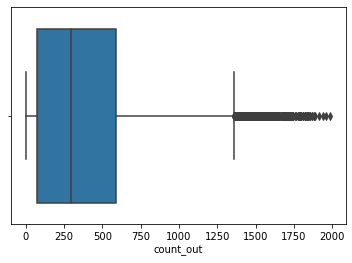

In [8]:
# Plotten von Ausreißern
sn.boxplot(x=df_total['count_out'])

In [9]:
#Entfernen von Ausreißern --> Berechnet z-score um die Abweichung eines Wertes vom Mittelwert zu ermitteln. Entfernt werden alle Werte,
# die einen z-score >3 haben, da hier die Abweichung besonders hoch ist.
from scipy import stats
import numpy as np


z = np.abs(stats.zscore(df_total))

threshold = 3
df_total = df_total[(z < 3).all(axis=1)]

In [10]:
#Entfernen von Ausreißern
from scipy import stats
import numpy as np


z = np.abs(stats.zscore(df_total_station))

threshold = 3
df_total_station = df_total_station[(z < 3).all(axis=1)]

In [11]:
df_total.reset_index(inplace = True)

In [12]:
df_total_station.reset_index(inplace=True)

<AxesSubplot:xlabel='count_out'>

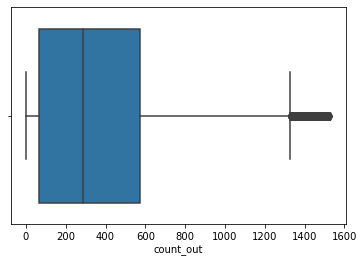

In [13]:
sn.boxplot(x=df_total['count_out'])

Während des Data Understanding wurden die Orginaldaten um Informationen zu Feiertagen und Wetter ergänzt. Da für das Prognosemodell aggregierte Daten benötigt werden, wurde auf die Rohdaten zurückgegriffen um die Aggregation zu vereinfachen. Die Informationen zu Wetter und Feiertagen müssen nun wieder ergänzt werden. Dies geschieht in den folgenden Schritten. Zuerst werden die beiden Wetter-Datensätze zusammengeführt und die Nullwerte aufgefüllt. Da man davon ausgehen kann, dass das Wetter innerhalb einiger Stunden nur geringen Schwankungen unterliegt, werden die fehlenden Werte mit der ffill Methode aufgefüllt. D.h. ein fehlender Wert wird mit dem Wert des vorhergehenden DAtensatzes aufgefüllt, sofern dieser vorhanden ist. Es wurde definiert, dass mayimal 3 fehlende Werte, d.h. 3 aufeinanderfolgende Stunden, aufgefüllt werden dürfen.

In [14]:
#Wetter-Datenset wird um Spalten mit Datum und Stunde ergänzt --> nötig um Wetterdaten und Ausleihdaten zusammenzufügen
df_weather_raw['date'] = df_weather_raw['time_ts'].apply(lambda dt: pd.Timestamp(dt.date()))
df_weather_raw['hour'] = df_weather_raw['time_ts'].apply(lambda dt: dt.time().hour)
df_weather_raw = df_weather_raw.drop('time_ts', axis = 1)
df_weather_raw = df_weather_raw.drop_duplicates(subset = ['date', 'hour'])

#Die beiden Wetter-Datensätze werden zusammengeführt
df_weather = df_weather_raw.combine_first(df_weather_alt)
df_weather = df_weather.drop_duplicates(subset = ['date', 'hour'])

# Nullwerte in den Wetterdaten auffüllen
df_weather['precipitation']=df_weather['precipitation'].fillna(method='ffill', limit = 3)
df_weather['winddirection'] = df_weather['winddirection'].fillna(method='ffill', limit =3)
df_weather['windspeed'] = df_weather['windspeed'].fillna(method='ffill', limit =2)
df_weather['pressure'] = df_weather['pressure'].fillna(method='ffill', limit =2)
df_weather['dewpoint'] = df_weather['dewpoint'].fillna(method='ffill', limit =1)
df_weather['humidity']=df_weather['humidity'].fillna(method='ffill', limit = 1)
df_weather['temperature']=df_weather['temperature'].fillna(method='ffill', limit = 1)


In [15]:
#Ergänzen um Feiertage
df_total['day_of_week'] = df_total['date'].dt.day
df_count_complete= pd.merge(df_total, df_holiday_data, left_on=df_total['date'], right_on=df_holiday_data['start_ts'], how='left').drop(['start_ts', 'key_0'], axis=1)
cal = calendar()
holidays = cal.holidays(start=min(df_count_complete['date']), end= max(df_count_complete['date']))
df_count_complete['Holiday'] = df_count_complete['date'].isin(holidays)

df_total_station['day_of_week'] = df_total_station['date'].dt.day
df_count_complete_station= pd.merge(df_total_station, df_holiday_data, left_on=df_total_station['date'], right_on=df_holiday_data['start_ts'], how='left').drop(['start_ts', 'key_0'], axis=1)
cal = calendar()
holidays = cal.holidays(start=min(df_count_complete_station['date']), end= max(df_count_complete_station['date']))
df_count_complete_station['Holiday'] = df_count_complete_station['date'].isin(holidays)

In [16]:
#Ergänzen um Wetterdaten
df_count_weather= pd.merge(df_count_complete, df_weather, on=['date', 'hour'], how='left')
df_count_weather_station= pd.merge(df_count_complete_station, df_weather, on=['date', 'hour'], how='left')


In [17]:
# Löschen überflüssiger Spalten
df_count_weather = df_count_weather.drop(['Reason'], axis=1)
df_count_weather_station = df_count_weather_station.drop(['Reason'], axis=1)

Das Data Understanding hat gezeigt, dass die Ausleihzahlen abhängig vom Wochentag sind. Unter der Woche liegt ein anderes Ausleihmuster vor, als an Wochenenden und Feiertagen. Um diese Information im Prognosemodell berücksichtigen zu können werden Wochentage ergänzt und die Information bzgl. Arbeitstag und Wochenende extrahiert.

In [18]:
#Wochentage ergänzen
df_count_weather['weekday'] = df_count_weather['date'].dt.day_name()
df_count_weather_station['weekday'] = df_count_weather_station['date'].dt.day_name()

In [19]:
# Variable Workingday basierend auf Wochentagen erstellen (1 für Werktag, 0 für Wochenende)
df_count_weather['workingday'] = df_count_weather['weekday'].replace(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],1)
df_count_weather['workingday'] = df_count_weather['workingday']. replace(['Saturday', 'Sunday'],0)

df_count_weather_station['workingday'] = df_count_weather_station['weekday'].replace(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],1)
df_count_weather_station['workingday'] = df_count_weather_station['workingday']. replace(['Saturday', 'Sunday'],0)

In [20]:
# Variable workingday anpassen, wenn es sich bei Werktag um Feiertag handelt
df_count_weather.loc[df_count_weather['Holiday'] == True, 'workingday'] = 0
df_count_weather.loc[df_count_weather['Holiday']== False, 'workingday'] = 1

df_count_weather_station.loc[df_count_weather_station['Holiday'] == True, 'workingday'] = 0
df_count_weather_station.loc[df_count_weather_station['Holiday']== False, 'workingday'] = 1

Da auch eine Saisonalität der Daten abhängig von der jeweiligen Jahreszeit vorliegt, werden auch Informationen über diese ergänzt. Hierbei werden Dezember, Januar und Februar zu Winter zusammengefasst; März, April und Mai zu Frühling; Juni, Juli, August zu Sommer und September, Oktober, November zu Herbst.

In [21]:
df_count_weather.loc[df_count_weather['date'].dt.month.apply(lambda x: x in [1,2,12]), 'Season']='Winter'
df_count_weather.loc[df_count_weather['date'].dt.month.apply(lambda x: x in [3,4,5]), 'Season']='Spring'
df_count_weather.loc[df_count_weather['date'].dt.month.apply(lambda x: x in [6,7,8]), 'Season']='Summer'
df_count_weather.loc[df_count_weather['date'].dt.month.apply(lambda x: x in [9,10,11]), 'Season']='Fall'

df_count_weather_station.loc[df_count_weather_station['date'].dt.month.apply(lambda x: x in [1,2,12]), 'Season']='Winter'
df_count_weather_station.loc[df_count_weather_station['date'].dt.month.apply(lambda x: x in [3,4,5]), 'Season']='Spring'
df_count_weather_station.loc[df_count_weather_station['date'].dt.month.apply(lambda x: x in [6,7,8]), 'Season']='Summer'
df_count_weather_station.loc[df_count_weather_station['date'].dt.month.apply(lambda x: x in [9,10,11]), 'Season']='Fall'

Ein weiterer wichtiger Schritt der Datenaufbereitung ist das Prüfen und Behandeln von Null-Werten. Damit die Daten für die verschiedensten Algorithmen verwendet werden können dürfen diese keine Nullwerte enthalten. Oben wurden bereits die Nullwerte in den Wetterdaten aufgefüllt. Im Folgenden werden nun die aggregierten und um die Wetterwerte angereicherten Ausleihdaten auf vollständigkeit geprüft. Da es im Verhältnis zur Gesamtzahl der Datensätze nur eine geringe Anzahl an Nullwerten gibt, werden alle Zeilen mit Nullwerten gelöscht.

In [22]:
df_count_weather.isnull().sum()

date             0
hour             0
count_in         0
count_out        0
day_of_week      0
Holiday          0
dewpoint         3
humidity         3
precipitation    3
pressure         3
temperature      3
winddirection    3
windspeed        3
weekday          0
workingday       0
Season           0
dtype: int64

In [23]:
df_count_weather_station.isnull().sum()

date               0
hour               0
station_id         0
count_in           0
count_out          0
day_of_week        0
Holiday            0
dewpoint         743
humidity         743
precipitation    743
pressure         743
temperature      743
winddirection    743
windspeed        743
weekday            0
workingday         0
Season             0
dtype: int64

In [24]:
df_count_weather = df_count_weather.dropna()
df_count_weather_station = df_count_weather_station.dropna()

In [25]:
df_count_weather.set_index(['date'], inplace = True)
df_count_weather['year'] = [x.year for x in df_count_weather.index]

df_count_weather_station.set_index(['date'], inplace = True)
df_count_weather_station['year'] = [x.year for x in df_count_weather_station.index]

In [26]:
df_count_weather.reset_index(['date'], inplace = True)
df_count_weather_station.reset_index(['date'], inplace = True)

Das Datenset enthält kategorische Variablen, wie z.B. Wochentag, Stunde oder Jahreszeit. Diese Variablen werden zwar als numerische Werte repräsentiert, haben aber alle das gleiche Gewicht. Um diese Variablen für die Modellierung verwenden zu können, werden mittels One-Hot Encoding Dummy-Variabeln erstellt. Für jeden eindeutigen Wert einer Variable wird eine Spalte erstellt. Diese enthält eine 1, wenn in der ursprünglichen Spalte dieser Wert enthalten war. Ansonsten werden die Felder mit Nullen gefüllt. Es entsteht somit ein Binär-Vektor für jedes einzelne Feature

In [27]:
category_list = ['date', 'hour', 'weekday']
for var in category_list:
    df_count_weather[var] = df_count_weather[var].astype('category')

for var in category_list:
    df_count_weather_station[var] = df_count_weather_station[var].astype('category')

In [28]:
df_count_weather= pd.get_dummies(df_count_weather, columns=['Season'])
#df_count_weather=pd.get_dummies(df_count_weather, columns =['month'], prefix='month')
df_count_weather=pd.get_dummies(df_count_weather, columns =['hour'], prefix='hour')
df_count_weather=pd.get_dummies(df_count_weather, columns =['weekday'])

df_count_weather_station= pd.get_dummies(df_count_weather_station, columns=['Season'])
#df_count_weather=pd.get_dummies(df_count_weather, columns =['month'], prefix='month')
df_count_weather_station=pd.get_dummies(df_count_weather_station, columns =['hour'], prefix='hour')
df_count_weather_station=pd.get_dummies(df_count_weather_station, columns =['weekday'])

Das Erstellen von Dummy-Variablen führt dazu, dass eine der erstellten Variablen eines Features mittels der anderen Variablen vorhergesagt werden kann. Es entsteht das Problem der Multikolinearität, sprich der Abhängigkeit unabhängiger (erklärender) Features. Dies kann bei einigen Modellen wie z.B. linerarer oder logistischer Regression zu Problemen führen. Gelöst werden kann die Multikolinearität, indem jeweils eine der erstellten Dummy-Variablen gelöscht wird (https://www.analyticsvidhya.com/blog/2020/03/one-hot-encoding-vs-label-encoding-using-scikit-learn/).

In [29]:
df_count_weather=df_count_weather.drop(['Season_Winter', 'hour_23', 'weekday_Sunday'], axis=1)
df_count_weather_station=df_count_weather_station.drop(['Season_Winter', 'hour_23', 'weekday_Sunday'], axis=1)

Als nächstes werden nicht mehr benötigte Spalten gelöscht. 

In [30]:
df_count_weather = df_count_weather.drop(['Holiday'], axis=1)
df_count_weather_station = df_count_weather_station.drop(['Holiday'], axis=1)

Abschließend werden die aufbereiteten Daten als pickle-Datei exportiert bevor final die Trainings- und Testdaten für die Modellierung erstellt werden. Hierbei bilden die Daten aus den Jahren 2015 und 2016 die Trainingsdaten, die Daten aus 2017 werden als Testdaten verwendet.

In [33]:
df_count_weather.to_pickle(DATA_PATH+'counts_prepared.pkl')
df_count_weather_station.to_pickle(DATA_PATH+'counts_prepared_stations.pkl')

In [35]:
array = [2015, 2016]

dataTrain = df_count_weather.loc[df_count_weather['year'].isin(array)]
dataTrain = dataTrain.sort_values(by=['date'])
dataTest = df_count_weather.loc[df_count_weather['year']==2017]
dataTest = dataTest.sort_values(by=['date'])

datetimecol = dataTest['date']
yLabels = df_count_weather["count_out"]


dataTrainStations = df_count_weather_station.loc[df_count_weather_station['year'].isin(array)]
dataTrainStations = dataTrainStations.sort_values(by=['date'])
dataTestStations = df_count_weather_station.loc[df_count_weather_station['year']==2017]
dataTestStations = dataTestStations.sort_values(by=['date'])


In [36]:
dataTrainStations.to_pickle(DATA_PATH+'training_stations.pkl')
dataTestStations.to_pickle(DATA_PATH+'test_stations.pkl')